In [1]:
from datetime import timedelta

import matplotlib.pyplot as plt
import pandas as pd
from scipy import integrate

plt.rcParams["savefig.dpi"] = 240

In [2]:
sm15k = pd.read_parquet("data/sm15k.parquet", columns=["time", "voltage", "current"]).set_index("time")
un38_3 = pd.read_csv("../UN38.3/cycles.csv", index_col="cycle")

sm15k.describe()

,voltage,current
count,8.298851e+06,8.298851e+06
mean,2.273753e+01,4.067698e-01
std,2.247938e+00,5.736020e+01
min,1.500150e+01,-1.703177e+02
25%,2.108820e+01,-7.200460e+01
50%,2.308910e+01,3.270000e-02
75%,2.516930e+01,7.197190e+01
max,2.521600e+01,7.270820e+01


In [3]:
from typing import Callable


def find_rising_edges(condition: pd.Series, drop: bool = True) -> pd.Series:
    mask = condition.astype(int).diff().fillna(0).astype(int) == 1
    if drop:
        return condition.loc[mask]
    return mask


def refine_condition(
    data: pd.Series,
    fn: Callable[[pd.DataFrame], bool],
    df: pd.DataFrame = sm15k,
    dt: timedelta = timedelta(seconds=20),
) -> pd.Series:
    data = data.copy()
    data.index = pd.Index([fn(df.loc[ts - dt : ts + dt]).idxmax() for ts in data.index], name=data.index.name)
    return data

In [4]:
_current = sm15k.loc["2024-10-25 17:30+00:00":, "current"].resample("10s").mean().interpolate(method="linear")

discharge_start = (
    find_rising_edges(_current < -24).pipe(refine_condition, fn=lambda df: df.current < -1).rename("discharge_start")
)
discharge_end = (
    find_rising_edges(_current > -24).pipe(refine_condition, fn=lambda df: df.current > -1).rename("discharge_end")
)
charge_start = (
    find_rising_edges(_current > 24).pipe(refine_condition, fn=lambda df: df.current > 1).rename("charge_start")
)
charge_end = (
    find_rising_edges(_current < 600e-3).pipe(refine_condition, fn=lambda df: df.current < -600e-3).rename("charge_end")
)

_df = pd.concat([discharge_start, discharge_end, charge_start, charge_end], axis=1).fillna(0).astype(bool)

assert all(_df[_df.sum(axis=1) == 1])
display(_df.sum(axis=0))

discharge_start    86
discharge_end      86
charge_start       86
charge_end         85
dtype: int64

In [5]:
cycles = pd.concat(
    [
        discharge_start.reset_index().time.dt.floor("100ms").rename("dsg_start"),
        discharge_end.reset_index().time.dt.ceil("100ms").rename("dsg_end"),
        charge_start.reset_index().time.dt.floor("100ms").rename("chg_start"),
        charge_end.reset_index().time.dt.ceil("100ms").rename("chg_end"),
    ],
    axis=1,
)
cycles.index = pd.RangeIndex(1, len(cycles) + 1, name="cycle")

df = sm15k.resample("100ms").mean().interpolate()
df["power"] = df["voltage"] * df["current"]
df["cycle"] = -1
df["phase"] = ""

for cycle, cs, ce, ds, de in cycles[["chg_start", "chg_end", "dsg_start", "dsg_end"]].dropna().itertuples():
    df.loc[cs:ce, "cycle"] = cycle
    df.loc[ds:de, "cycle"] = cycle
    df.loc[cs:ce, "phase"] = "charge"
    df.loc[ds:de, "phase"] = "discharge"

charge_Ah = (
    df.loc[df["cycle"] != -1]
    .groupby(["cycle", "phase"])["current"]
    .aggregate(integrate.trapezoid, dx=0.1)
    .divide(3600)
    .unstack()
)
energy_Wh = (
    df.loc[df["cycle"] != -1]
    .groupby(["cycle", "phase"])["power"]
    .aggregate(integrate.trapezoid, dx=0.1)
    .divide(3600)
    .unstack()
)

cycles["dsg_start"] = cycles["dsg_start"].dt.floor("1s")
cycles["dsg_end"] = cycles["dsg_end"].dt.ceil("1s")
cycles["chg_start"] = cycles["chg_start"].dt.floor("1s")
cycles["chg_end"] = cycles["chg_end"].dt.ceil("1s")

cycles["dsg_duration"] = cycles["dsg_end"] - cycles["dsg_start"]
cycles["chg_duration"] = cycles["chg_end"] - cycles["chg_start"]
cycles["dsg_charge_Ah"] = charge_Ah["discharge"]
cycles["chg_charge_Ah"] = charge_Ah["charge"]
cycles["dsg_energy_Wh"] = energy_Wh["discharge"]
cycles["chg_energy_Wh"] = energy_Wh["charge"]
cycles["energy_loss_Wh"] = cycles["chg_energy_Wh"] + cycles["dsg_energy_Wh"]

cycles.to_csv("cycles.csv")


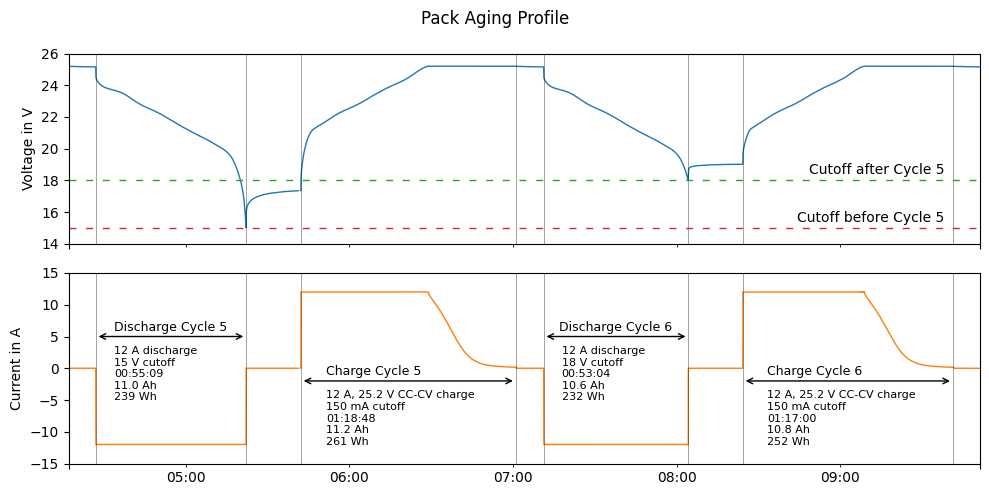

In [6]:
from matplotlib.patches import FancyArrowPatch

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

start = cycles.loc[5, "dsg_start"] - timedelta(minutes=10)
end = cycles.loc[6, "chg_end"] + timedelta(minutes=10)

sm15k.loc[start:end, "voltage"].resample("1s").mean().plot(ax=ax1, lw=1, c="C0", ylim=(14, 26))
sm15k.loc[start:end, "current"].resample("1s").mean().div(6).plot(ax=ax2, lw=1, c="C1", ylim=(-15, 15))

# Mark discharge and charge phases
for cycle, row in cycles.loc[5:6].iterrows():
    for ax in [ax1, ax2]:
        ax.axvline(row["dsg_start"], c="k", alpha=0.5, lw=0.5)
        ax.axvline(row["dsg_end"], c="k", alpha=0.5, lw=0.5)
        ax.axvline(row["chg_start"], c="k", alpha=0.5, lw=0.5)
        ax.axvline(row["chg_end"], c="k", alpha=0.5, lw=0.5)

    arrow = FancyArrowPatch(
        (row["dsg_start"], 5),
        (row["dsg_end"], 5),
        arrowstyle="<->",
        mutation_scale=10,
    )
    ax2.add_patch(arrow)
    ax2.annotate(
        f"Discharge Cycle {cycle}",
        xy=(0.5, 1),
        xycoords=arrow,
        ha="center",
        va="bottom",
        fontsize=9,
    )
    cutoff = 15 if cycle <= 5 else 18
    dur = row["dsg_duration"].components
    ax2.annotate(
        f"12 A discharge\n"
        f"{cutoff} V cutoff\n"
        f"{dur.hours:02d}:{dur.minutes:02d}:{dur.seconds:02d}\n"
        f"{abs(row['dsg_charge_Ah'])/6:.1f} Ah\n"
        f"{abs(row['dsg_energy_Wh'])/6:.0f} Wh",
        xy=(0.1, -1.2),
        xycoords=arrow,
        ha="left",
        va="top",
        fontsize=8,
    )

    arrow = FancyArrowPatch(
        (row["chg_start"], -2),
        (row["chg_end"], -2),
        arrowstyle="<->",
        mutation_scale=10,
    )
    ax2.add_patch(arrow)
    ax2.annotate(
        f"Charge Cycle {cycle}",
        xy=(0.1, 1),
        xycoords=arrow,
        ha="left",
        va="bottom",
        fontsize=9,
    )
    dur = row["chg_duration"].components
    ax2.annotate(
        f"12 A, 25.2 V CC-CV charge\n"
        f"150 mA cutoff\n"
        f"{dur.hours:02d}:{dur.minutes:02d}:{dur.seconds:02d}\n"
        f"{abs(row['chg_charge_Ah'])/6:.1f} Ah\n"
        f"{abs(row['chg_energy_Wh'])/6:.0f} Wh",
        xy=(0.1, -1.2),
        xycoords=arrow,
        ha="left",
        va="top",
        fontsize=8,
    )

ax1.axhline(15, c="C3", ls=(0, (5, 7)), lw=1)
ax1.axhline(18, c="C2", ls=(0, (5, 7)), lw=1)

ax1.text(cycles.loc[6, "chg_end"] - timedelta(minutes=3), 15.2, "Cutoff before Cycle 5", ha="right", va="bottom")
ax1.text(cycles.loc[6, "chg_end"] - timedelta(minutes=3), 18.2, "Cutoff after Cycle 5", ha="right", va="bottom")

ax1.set_ylabel("Voltage in V")
ax2.set_ylabel("Current in A")
ax2.set_xlabel(None)

fig.suptitle("Pack Aging Profile")
fig.tight_layout()
fig.savefig("img/aging-profile.png", dpi=240)

In [7]:
display(cycles)

,dsg_start,dsg_end,chg_start,chg_end,dsg_duration,chg_duration,dsg_charge_Ah,chg_charge_Ah,dsg_energy_Wh,chg_energy_Wh,energy_loss_Wh
cycle,,,,,,,,,,,
1,2024-10-25 17:30:21+00:00,2024-10-25 18:25:23+00:00,2024-10-25 18:45:22+00:00,2024-10-25 20:04:00+00:00,0 days 00:55:02,0 days 01:18:38,-66.004164,66.992595,-1421.367161,1563.582689,142.215527
2,2024-10-25 20:14:18+00:00,2024-10-25 21:09:29+00:00,2024-10-25 21:29:29+00:00,2024-10-25 22:48:00+00:00,0 days 00:55:11,0 days 01:18:31,-66.198283,67.090885,-1431.432681,1565.322924,133.890243
3,2024-10-25 22:58:25+00:00,2024-10-25 23:53:37+00:00,2024-10-26 00:13:36+00:00,2024-10-26 01:32:20+00:00,0 days 00:55:12,0 days 01:18:44,-66.213236,67.096725,-1432.343945,1565.472723,133.128778
4,2024-10-26 01:42:40+00:00,2024-10-26 02:37:51+00:00,2024-10-26 02:57:50+00:00,2024-10-26 04:16:40+00:00,0 days 00:55:11,0 days 01:18:50,-66.187203,67.074803,-1432.043489,1565.038453,132.994964
5,2024-10-26 04:26:58+00:00,2024-10-26 05:22:07+00:00,2024-10-26 05:42:12+00:00,2024-10-26 07:01:00+00:00,0 days 00:55:09,0 days 01:18:48,-66.150296,67.032958,-1431.433779,1564.168470,132.734691
...,...,...,...,...,...,...,...,...,...,...,...
82,2024-11-03 18:29:58+00:00,2024-11-03 19:21:53+00:00,2024-11-03 19:41:52+00:00,2024-11-03 21:00:40+00:00,0 days 00:51:55,0 days 01:18:48,-62.274791,63.148537,-1359.250754,1483.839394,124.588641
83,2024-11-03 21:11:04+00:00,2024-11-03 22:02:59+00:00,2024-11-03 22:22:58+00:00,2024-11-03 23:41:50+00:00,0 days 00:51:55,0 days 01:18:52,-62.264651,63.138424,-1359.015131,1483.625005,124.609874
84,2024-11-03 23:52:15+00:00,2024-11-04 00:44:09+00:00,2024-11-04 01:04:08+00:00,2024-11-04 02:23:10+00:00,0 days 00:51:54,0 days 01:19:02,-62.254999,63.128500,-1358.782729,1483.427127,124.644397


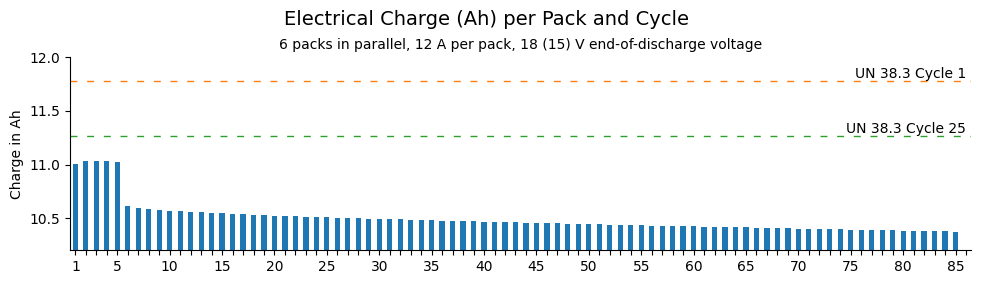

In [8]:
ax = cycles["dsg_charge_Ah"].mul(-1).div(6).plot.bar(figsize=(10, 3), ylim=(10.2, 12), ylabel="Charge in Ah")
plt.suptitle("Electrical Charge (Ah) per Pack and Cycle", y=0.93, fontsize=14)
ax.set_title(
    "6 packs in parallel, 12 A per pack, 18 (15) V end-of-discharge voltage",
    fontsize=10,
)

q01 = -un38_3.loc[1, "dsg_charge_Ah"] / 4
q25 = -un38_3.loc[25, "dsg_charge_Ah"] / 4
ax.axhline(q01, c="C1", ls=(0, (5, 7)), lw=1)
ax.axhline(q25, c="C2", ls=(0, (5, 7)), lw=1)
ax.text(len(cycles) - 1, q01, "UN 38.3 Cycle 1", ha="right", va="bottom")
ax.text(len(cycles) - 1, q25, "UN 38.3 Cycle 25", ha="right", va="bottom")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel(None)
ax.tick_params(axis="x", rotation=0)

# Show only every 5th x-tick label
for idx, label in enumerate(ax.get_xticklabels(), start=1):
    if idx != 1 and idx % 5 != 0:
        label.set_visible(False)

plt.tight_layout()
plt.savefig("img/charge-per-cycle.png")


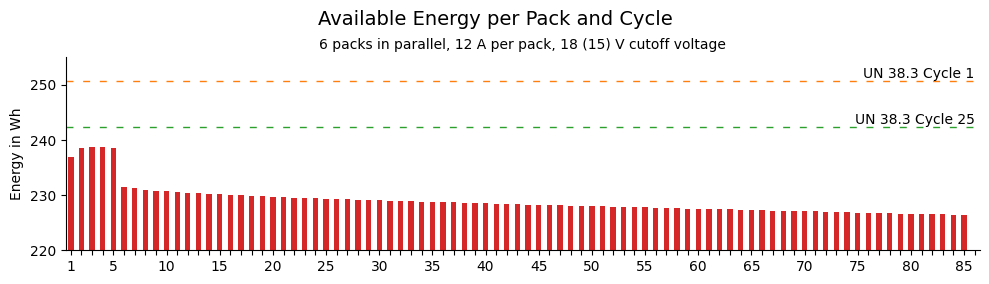

In [9]:
ax = cycles["dsg_energy_Wh"].div(-6).plot.bar(figsize=(10, 3), ylim=(220, 255), ylabel="Energy in Wh", color="C3")
plt.suptitle("Available Energy per Pack and Cycle", y=0.93, fontsize=14)
ax.set_title(
    "6 packs in parallel, 12 A per pack, 18 (15) V cutoff voltage",
    fontsize=10,
)

e01 = -un38_3.loc[1, "dsg_energy_Wh"] / 4
e25 = -un38_3.loc[25, "dsg_energy_Wh"] / 4
ax.axhline(e01, c="C1", ls=(0, (5, 7)), lw=1)
ax.axhline(e25, c="C2", ls=(0, (5, 7)), lw=1)
ax.text(len(cycles) - 1, e01, "UN 38.3 Cycle 1", ha="right", va="bottom")
ax.text(len(cycles) - 1, e25, "UN 38.3 Cycle 25", ha="right", va="bottom")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel(None)
ax.tick_params(axis="x", rotation=0)

# Show only every 5th x-tick label
for idx, label in enumerate(ax.get_xticklabels(), start=1):
    if idx != 1 and idx % 5 != 0:
        label.set_visible(False)

plt.tight_layout()
plt.savefig("img/energy-per-cycle.png")


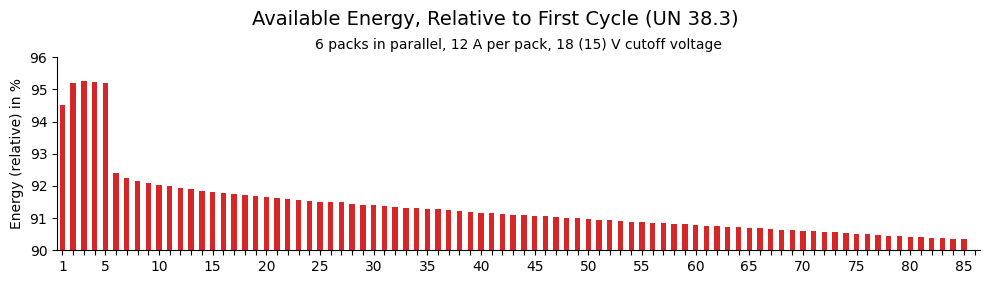

In [10]:
ax = (
    cycles["dsg_energy_Wh"]
    .div(6)
    .div(un38_3.loc[1, "dsg_energy_Wh"] / 4)
    .mul(100)
    .plot.bar(figsize=(10, 3), ylim=(90, 96), ylabel="Energy (relative) in %", color="C3")
)
plt.suptitle("Available Energy, Relative to First Cycle (UN 38.3)", y=0.93, fontsize=14)
ax.set_title(
    "6 packs in parallel, 12 A per pack, 18 (15) V cutoff voltage",
    fontsize=10,
)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel(None)
ax.tick_params(axis="x", rotation=0)

# Show only every 5th x-tick label
for idx, label in enumerate(ax.get_xticklabels(), start=1):
    if idx != 1 and idx % 5 != 0:
        label.set_visible(False)

plt.tight_layout()
plt.savefig("img/relative-energy-per-cycle.png")
